In [2]:
import os
from functools import partial

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsmodels.tsa.seasonal import seasonal_decompose

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape, mase
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Markdown, Image

from fpppy.utils import plot_series

# endregion 
from plotnine import *

# change working directory 
# Check if current directory has any .ipynb files
if any(fname.endswith(".ipynb") for fname in os.listdir()):
    os.chdir("..")

# load local package modules

%load_ext autoreload
%autoreload 2

In [10]:
def print_regression_summary_from_model(model):
    X = model._X.values.astype(float)
    y = model._y
    residuals = model._residuals

    n, p = X.shape
    X_design = np.hstack([np.ones((n, 1)), X])
    df = n - p - 1

    res_summary = np.percentile(residuals, [0, 25, 50, 75, 100])
    print("#> Residuals:")
    print(f"#>     Min      1Q  Median      3Q     Max ")
    print(f"#> {res_summary[0]:7.4f} {res_summary[1]:7.4f} "
          f"{res_summary[2]:7.4f} {res_summary[3]:7.4f} "
          f"{res_summary[4]:7.4f}\n")

    coef = np.insert(model.coef_, 0, model.intercept_)
    rss = np.sum(residuals ** 2)
    mse = rss / df
    var_beta = mse * np.linalg.inv(X_design.T @ X_design).diagonal()
    se_beta = np.sqrt(var_beta)
    t_stats = coef / se_beta
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df))

    print("#> Coefficients:")
    print(f"#> {'':>13} {'Estimate':>9} {'Std. Error':>11} {'t value':>9} "
          f"{'Pr(>|t|)':>9}")
    names = ['(Intercept)'] + model._var_names
    for name, est, se, t, p in zip(names, coef, se_beta, t_stats, p_values):
        stars = (
            '***' if p < 0.001 else
            '**' if p < 0.01 else
            '*' if p < 0.05 else
            '.' if p < 0.1 else
            ''
        )
        print(f"#> {name:>13} {est:9.4f} {se:11.4f} {t:9.2f} {p:9.3g} "
              f"{stars}")
    print("---")
    print("Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")

    r_squared = model.score(X, y)
    adj_r_squared = 1 - (1 - r_squared) * (n - 1) / df
    f_stat = (r_squared / p) / ((1 - r_squared) / df)
    f_pval = 1 - stats.f.cdf(f_stat, p, df)

    print(f"\nResidual standard error: {np.sqrt(mse):.3f} "
          f"on {df} degrees of freedom")
    print(f"Multiple R-squared: {r_squared:.3f},   "
          f"Adjusted R-squared: {adj_r_squared:.3f}")
    print(f"F-statistic: {f_stat:.1f} on {p} and {df} DF, "
          f"p-value: {f_pval:.3g}")

## 1.3. Some simpler time series models

Technically, a **time series model** provides a complete probabilistic model  that specifies all the joint distributions of random vectors ($X_1, ..., X_n$). That is, the probability at each *n* time point that the variable ($X_n$) would be less than or equal to any possible value of $- \infty < x_1, ..., x_n < \infty$. Mathematically, 

$$
P[X_1 \le x_1,..., X_n \le x_n], \infty < x_1, ..., x_n < \infty. n=, 1,2,...
$$

Because this is not practically feasible, only the mean and variance of the joint distributions are modelled (i..e, second-order properties). The theory of minimium mean sqare errors justifies use of second-order properties and guarantees that little information is lost. 

### 1.3.2. Models with trend and seasonality 

First example below fits a second-order polynomial model to US population growth (in each decade) from 1790 to 1990. Parameter values are obtained by minimizing sum of squared error. 

$$ 
\hat{y}_t = a_0 + a_1t + a_2 t^2
$$

In [ ]:
# Example 1.3.4. Population of the US with time-varying trend component 
df_us_pop = pd.read_csv('data/raw/uspop.tsm', names=['y'])

# add standard columns needed by nixtla functions 
df_us_pop['unique_id'] = 'us_pop'
n_obs = len(df_us_pop)
df_us_pop['ds'] = pd.date_range(start='1790-01-01', periods=n_obs, freq='10YS')

# add numeric time values to be used as predictors
df_us_pop['time'] = np.arange(1, len(df_us_pop) + 1)
df_us_pop['time_squared'] = df_us_pop['time']**2

from fpppy.models import LinearRegression
from mlforecast import MLForecast
from scipy import stats

mf = MLForecast(models=LinearRegression(), freq='10Y')

# Fit model
mf.fit(df_us_pop, fitted=True, static_features=[])

print_regression_summary_from_model(mf.models_['LinearRegression'])

df_pred = mf.forecast_fitted_values()

(ggplot(data=df_pred, mapping=aes(x='ds', y=df_pred['y']/1e6)) + 
    geom_point(size=2) + 
    geom_line(mapping=aes(x='ds', y=df_pred['LinearRegression']/1e6)) + 
    theme_classic())

MLForecast(models=[LinearRegression], freq=10Y, lag_features=[], date_features=[], num_threads=1)

#> Residuals:
#>     Min      1Q  Median      3Q     Max 
#> -6947525.8445 -358167.7780 436284.7166 1481410.7825 3391762.1306

#> Coefficients:
#>                Estimate  Std. Error   t value  Pr(>|t|)
#>   (Intercept) 6957920.8617 1998526.4589      3.48   0.00266 **
#>          time -2159870.0575 418437.5492     -5.16  6.55e-05 ***
#>  time_squared 650633.8684  18472.0687     35.22         0 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2766661.251 on 18 degrees of freedom
Multiple R-squared: 0.999,   Adjusted R-squared: 0.999
F-statistic: inf on 0.0 and 18 DF, p-value: nan


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
/var/folders/yc/2l2dbqc565l5ryrcfz4x3w680000gn/T/ipykernel_11915/3495411307.py:44: RuntimeWarning: divide by zero encountered in scalar divide


In the second example, a simple regression model is fit to the level of Lake Huron.  Examination of the residuals shows that the residuals are likely to be correlated as there are long stretches when residuals are positive and negative. 

MLForecast(models=[LinearRegression], freq=10Y, lag_features=[], date_features=[], num_threads=1)

#> Residuals:
#>     Min      1Q  Median      3Q     Max 
#> -2.5100 -0.7273  0.0008  0.7440  2.5357

#> Coefficients:
#>                Estimate  Std. Error   t value  Pr(>|t|)
#>   (Intercept)   10.2020      0.2301     44.34         0 ***
#>          time   -0.0242      0.0040     -6.00  3.55e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.130 on 96 degrees of freedom
Multiple R-squared: 0.272,   Adjusted R-squared: 0.265
F-statistic: 1014146480.1 on 3.545229620982582e-08 and 96 DF, p-value: 3.33e-16


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names


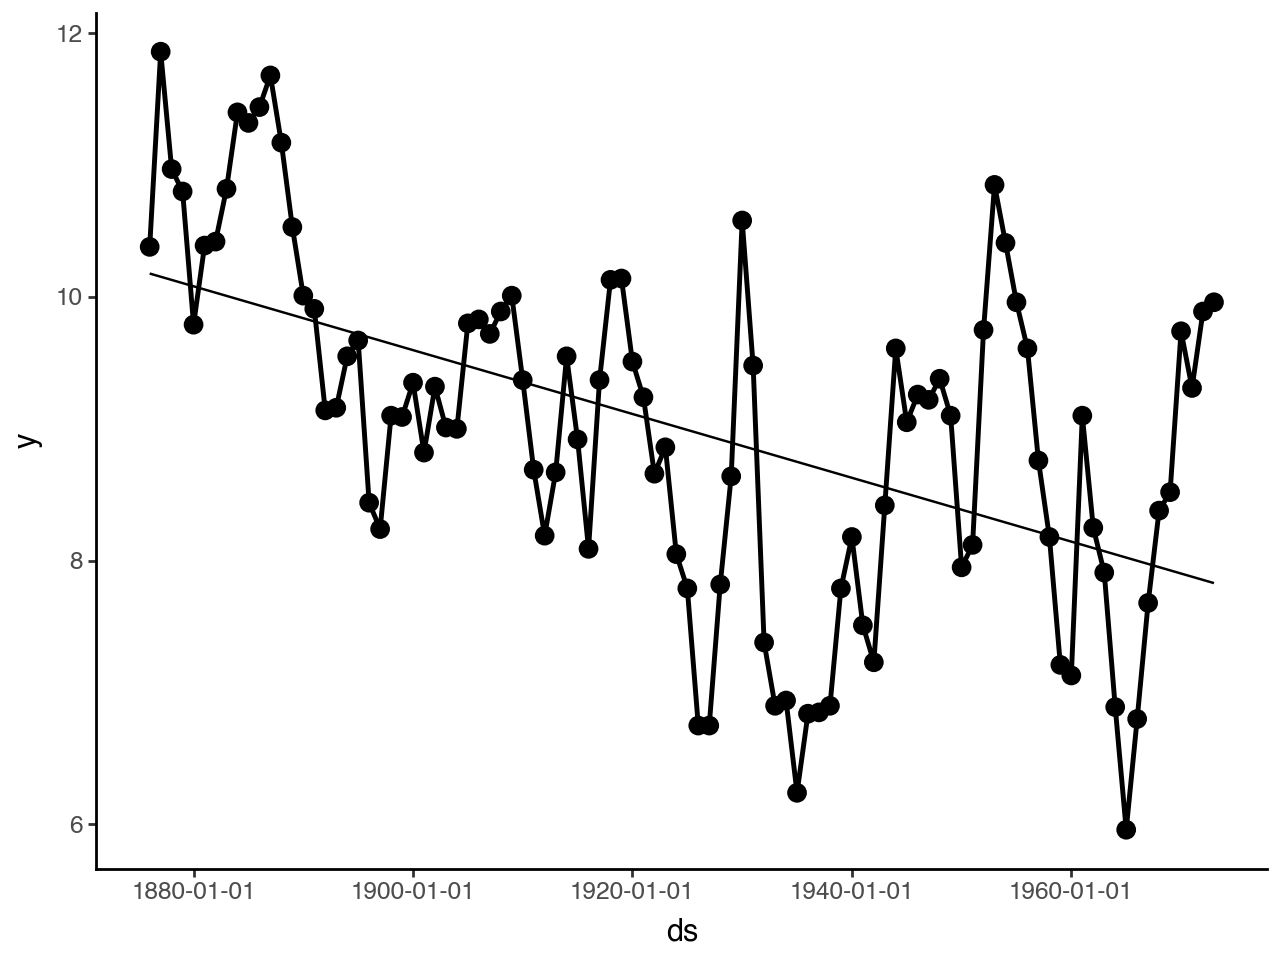

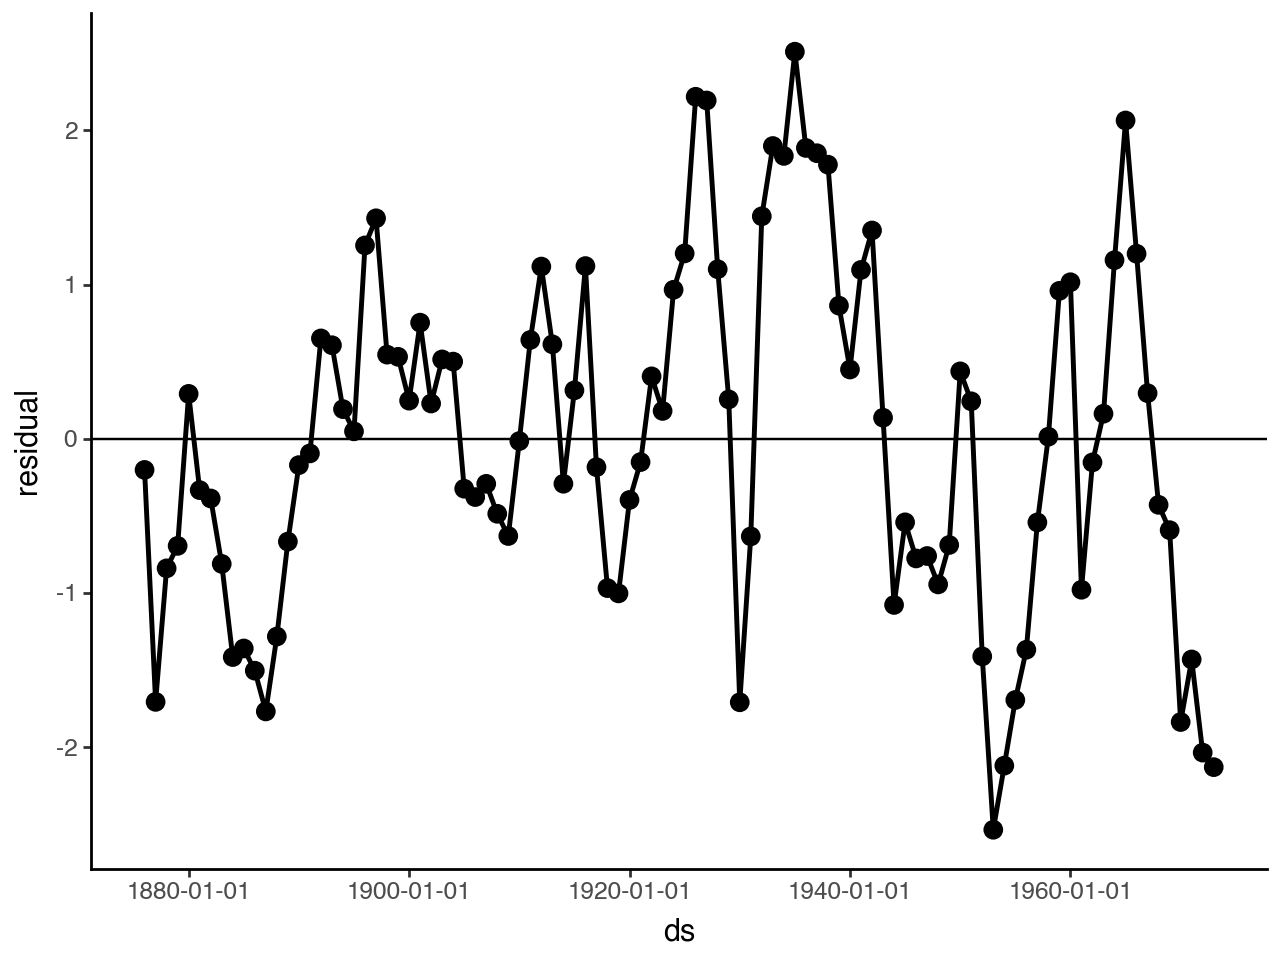

In [27]:
## Example 1.3.5. Level of Lake Huron from 1875 to 1972
df_us_pop = pd.read_csv('data/raw/lake.tsm', names=['y'])

# add standard columns needed by nixtla functions 
df_us_pop['unique_id'] = 'lake_huron'
n_obs = len(df_us_pop)
df_us_pop['ds'] = pd.date_range(start='1875-01-01', periods=n_obs, freq='YE')

# add numeric time values to be used as predictors
df_us_pop['time'] = np.arange(1, len(df_us_pop) + 1)

from fpppy.models import LinearRegression
from mlforecast import MLForecast
from scipy import stats

mf = MLForecast(models=LinearRegression(), freq='10Y')

# Fit model
mf.fit(df_us_pop, fitted=True, static_features=[])

print_regression_summary_from_model(mf.models_['LinearRegression'])

df_pred = mf.forecast_fitted_values()
df_pred['residual'] = (df_pred['LinearRegression'] - df_pred['y'])

(ggplot(data=df_pred, mapping=aes(x='ds', y=df_pred['y'])) + 
    geom_line(size=1) + 
    geom_point(size=3) +
    geom_line(mapping=aes(x='ds', y=df_pred['LinearRegression'])) + 
    theme_classic())

(ggplot(data=df_pred, mapping=aes(x='ds', y=df_pred['residual'])) + 
    geom_line(size=1) + 
    geom_point(size=3) +
    geom_hline(mapping=aes(yintercept=0)) + 
    theme_classic())


### 1.3.3. A general approach to time series modeling 

1. Plot the series and check for trend, seasonality, sharp changes, and outliers
2. Remove trend and seasonality to get stationary residuals. Transformations may be needed here. 

## 1.4. Stationary models and the autocorrelation function 

